In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<hr>

## **1)** Five layer perceptron regressor

a) Load the data into a pandas DataFrame, and get a scikit-learn compatible dataset. Use
the “target” column as the target variable.

In [2]:
# Load the dataset
full_data_part1 = pd.read_csv("Part 1.tsv", sep="\t")

# Using only half of the data
partial_data = full_data_part1.head(int(full_data_part1.shape[0]/2))

features = [x for x in partial_data.columns.drop("target")]

X = partial_data[features]
y = partial_data["target"]

b) Make a 70%/30% split of the dataset for training and testing respectively.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print(f"Tamanho de treino: {X_train.shape}")
print(f"Tamanho de teste: {X_test.shape}")

Tamanho de treino: (3500, 6)
Tamanho de teste: (1500, 6)


c) Using numpy, create a scikit-learn regressor that implements a multilayer perceptron
architecture with 5 hidden layers.
- The dimensionality of each layer is your decision.
- Each hidden layer must have a bias unit.
- All activations should be the sigmoid function.
- You must use the backpropagation algorithm to calculate the derivatives.
- Use mini-batch gradient descent to update the weights.
- The parameters of the estimator are the following:
    - **learning_rate:** A float number that determines the learning rate used for
updating the weights on the update step of the gradient descent.
    - **batch_size**: An integer that determines the number of datapoints that
are included in each mini-batch.
    - **epochs**: An integer that determines the number of times the training
goes through all the datapoints

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

class FiveLayerPerceptronRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, batch_size=100, epochs=100, size_hidden=100):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.size_hidden = size_hidden

        self.rng = np.random.default_rng(0)

        self.training_losses = np.zeros(self.epochs)

    # function of sigmoid
    def _sigmoid(self, Z):
        return 1.0 / (1.0 + np.exp(-Z))

    # function of sigmoid derivative
    def _sigmoid_derivative(self, Z):
        x = self._sigmoid(Z)
        return x * (1 - x)

    # function of cost function
    def cost_function(self, y, y_hat):
        return np.sum(np.square(y_hat - y)) * 1/2 

    # function of accuracy
    def cost_gradient(self, y, y_hat):
        return (y_hat - y)

    # forward propagation
    def _forward_propagation(self, X):
        self.Z = []
        self.A = []

        # iterate over the hidden layers
        for i in range(5):
            self.Z.append((X @ self._W[i]))
            self.A.append(self._sigmoid(self.Z[i]))
            self.A[i] = np.c_[np.ones((self.A[i].shape[0],1)), self.A[i]]
            X = self.A[i]

        # last layer
        self.Z.append((self.A[-1] @ self._W[-1]))
        self.A.append(self.Z[-1])
        # return prediction

        return self.A[-1]

    # function of backward propagation for regression
    def _backward_propagation(self, X, y):
        dA = []
        dW = []
        delta = []

        # last layer
        dA.append(self.cost_gradient(y, self.A[-1]))
        delta.append(dA[0])
        dW.append((self.A[-2].T @ delta[0]))

        # iterate over the layers until the first hidden layer
        for i in range(5, 1, -1):   
            dA.append((delta[-1] @ self._W[i][1:,:].T))
            delta.append(dA[-1] * self._sigmoid_derivative(self.Z[i-1]))
            dW.append((self.A[i-2].T @ delta[-1]))

        # first layer
        dA.append((delta[-1] @ self._W[1][1:,:].T))
        delta.append(dA[-1] * self._sigmoid_derivative(self.Z[0]))
        dW.append((X.T @ delta[-1]))

        # reverse the order of dW
        dW.reverse()

        # return dW
        return dW
        
    # function of weight update
    def _weight_update(self, dW, curr):
        # update the weights
        for i in range(len(dW)):
            self._W[i] -= (self.learning_rate * dW[i]) / curr

    # function of training
    def fit(self, X, y):
        n, m = X.shape

        # prepare the inputs
        _X = np.c_[np.ones((n,1)), X]
        y = y.to_numpy()
        _y = y[:,np.newaxis]

        self._W = []

        # initialize the weights
        self._W.append(np.random.randn(m+1, self.size_hidden))
        for i in range(4):
            self._W.append(np.random.randn(self.size_hidden+1, self.size_hidden))
        self._W.append(np.random.randn(self.size_hidden+1, 1))

        n_batches = (n + self.batch_size - 1) // self.batch_size

        # iterate over the epochs
        for epoch in range(self.epochs):
            for b in range(n_batches):
                _X_batch = _X[b * self.batch_size : (b + 1) * self.batch_size]
                _y_batch = _y[b * self.batch_size : (b + 1) * self.batch_size]
                # get the predictions for the current weights
                y_pred = self._forward_propagation(_X_batch)
                curr_batch_size = _y_batch.shape[0]
                # update the weights
                dW = self._backward_propagation(_X_batch, _y_batch)
                self._weight_update(dW, curr_batch_size)
            # store the training loss for the current epoch
            y_pred = self._forward_propagation(_X)
            self.training_losses[epoch] = self.cost_function(_y, y_pred)

    # predict function
    def predict(self, X):
        n, m = X.shape
        _X = np.c_[np.ones((n, 1)), X]
        
        return self._forward_propagation(_X)

d) Train the estimator you implemented using the training set. Use the trained estimator
to predict values for the test set.

In [5]:
model = FiveLayerPerceptronRegressor(epochs=100, learning_rate=0.01, batch_size=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred[:5,:])

[[-277.60076259]
 [ -23.21560839]
 [ -77.09178557]
 [  60.1792081 ]
 [-210.2641528 ]]


e) Use the scikit-learn MLPRegressor estimator. Train it on the training test and generate
predictions for the test set.

In [6]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), \
    learning_rate_init=0.1, activation="logistic",\
    batch_size=100)
mlp.fit(X_train, y_train)
y_mlp_pred = mlp.predict(X_test)

f) Compare the performance of both models using the mean squared error metric from
scikit-learn

In [7]:
np.c_[y_pred, y_mlp_pred][:5,:]

array([[-277.60076259, -280.18966885],
       [ -23.21560839,  -25.10683992],
       [ -77.09178557,  -76.02656094],
       [  60.1792081 ,   60.90684015],
       [-210.2641528 , -205.71654599]])

In [8]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_mlp_pred))

13.495471287020667 9.145724557320888


Text(0.5, 1.0, 'Training Loss')

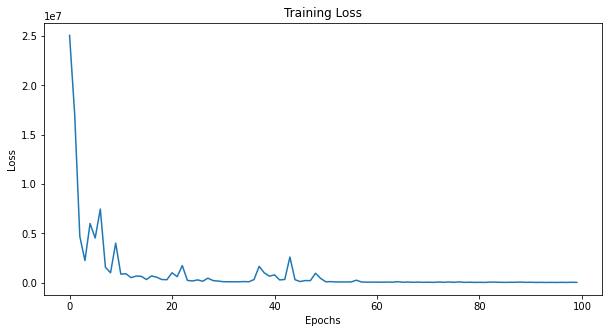

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(model.training_losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")

<hr>

## **2)** multi layers perceptron classifier

a) Load the data into a pandas DataFrame, and get a scikit-learn compatible dataset. Use
the “target” column as the target variable

In [10]:
# Load the dataset
full_data_part2 = pd.read_csv("Part 2.tsv", sep="\t")

# Using only half of the data
partial_data_2 = full_data_part2.head(int(full_data_part2.shape[0]))

features_2 = [x for x in partial_data_2.columns.drop("target")]

X_2 = partial_data_2[features_2]
y_2 = partial_data_2["target"]


b) Make a 70%/30% split of the dataset for training and testing respectively

In [11]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.30, random_state=0)

print(f"Tamanho de treino: {X_train_2.shape}")
print(f"Tamanho de teste: {X_test_2.shape}")

Tamanho de treino: (7000, 4)
Tamanho de teste: (3000, 4)


c) Using numpy, create a scikit-learn classifier that implements a multilayer perceptron
with the following parameters:
- Each hidden layer must have a bias unit.
- All activations should be the sigmoid function.
- You must use the backpropagation algorithm to calculate the derivatives.
- Use mini-batch gradient descent to update the weights.
- The parameters of the estimator are the following:
    - **hidden_layers_dimensions**: A list of integers that determines the number
and dimensionality of the hidden layers. The number of items on the list
determine the number of hidden layers. The first element of the list (at
index 0) is the dimensionality of the first hidden layer (connected to the
input). The last element is the dimensionality of the hidden layer
(connected to the output layer). The dimensionality does not include the
bias term. The dimensionality of the input and output layers should be
inferred from the dimensionality of the data.
For example: A list [4,3,2] will generate 3 hidden layers with dimensions
4, 3, and 2, respectively. If we count the bias units, the dimensions are 5,
4, 3.
    - **learning_rate**: A float number that determines the learning rate used for
updating the weights in gradient descent.
    - **batch_size**: An integer that determines the number of datapoints that
are included in each mini-batch.
    - **epochs**: An integer that determines the number of times the training
goes through all the datapoints.

In [12]:
# Class of a neural network for classification
class NeuralNetClass(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_dimensions, learning_rate, batch_size
                    , epochs):
        self.hidden_layer_dimensions = hidden_layer_dimensions
        self.size_of_hidden = len(hidden_layer_dimensions) # how many hidden layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.training_losses = np.zeros(self.epochs)
        self.rng = np.random.default_rng(3)

    # function of sigmoid
    def _sigmoid(self, Z):
        return 1.0 / (1.0 + np.exp(-Z))

    # function of sigmoid derivative
    def _sigmoid_derivative(self, Z):
        x = self._sigmoid(Z)
        return x * (1.0 - x)

    # function of cost function
    def cost_function(self, y, y_hat):
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    # function of cost function derivative
    def cost_gradient(self, y, y_hat):
        return -np.divide(y, y_hat) + np.divide(1.0 - y, 1.0 - y_hat)

    # function of forward propagation
    def _forward_propagation(self, X):
        self.Z = []
        self.A = []

        # iterate over the hidden layers
        for i in range(self.size_of_hidden):
            self.Z.append((X @ self._W[i]))
            self.A.append(self._sigmoid(self.Z[i]))
            self.A[i] = np.c_[np.ones((self.A[i].shape[0],1)), self.A[i]]
            X = self.A[i]

        # get the output layer
        self.Z.append((self.A[-1] @ self._W[-1]))
        self.A.append(self._sigmoid(self.Z[-1]))

        # return the output layer
        return self.A[-1]

    def _backward_propagation(self, X, y):
        dA = []
        dW = []
        dZ = []

        # last layer
        dA.append(self.cost_gradient(y, self.A[-1]))
        dZ.append(dA[0] * self._sigmoid_derivative(self.Z[-1]))
        dW.append(self.A[-2].T @ dZ[0])

        # iterate over the hidden layers
        for i in range(self.size_of_hidden, 1, -1):
            dA.append(dZ[-1] @ self._W[i][1:,:].T)
            dZ.append(dA[-1] * self._sigmoid_derivative(self.Z[i-1]))
            dW.append(self.A[i-2].T @ dZ[-1])
        
        # first layer
        dA.append(dZ[-1] @ self._W[1][1:,:].T)
        dZ.append(dA[-1] * self._sigmoid_derivative(self.Z[0]))
        dW.append(X.T @ dZ[-1])

        # reverse dW
        dW.reverse()

        # return dW
        return dW

    # function of weight update
    def _weight_update(self, dW, curr_batch_size):
        for i in range(len(self._W)):
            self._W[i] -= (self.learning_rate * dW[i])

    # function of training
    def fit(self, X, y):
        # get input right
        m, n = X.shape
        _X = np.c_[np.ones((m, 1)), X]
        y = y.to_numpy()
        _y = y[:, np.newaxis]

        # initialize weights
        self._W = []
        self._W.append(self.rng.normal(size=(n+1, self.hidden_layer_dimensions[0])))
        for i in range(1, self.size_of_hidden):
            self._W.append(self.rng.normal(size=(self.hidden_layer_dimensions[i-1]+1, self.hidden_layer_dimensions[i])))
        self._W.append(self.rng.normal(size=(self.hidden_layer_dimensions[-1]+1, 1)))

        n_batches = (n + self.batch_size - 1) // self.batch_size
        
        # iterate over the epochs
        for epoch in range(self.epochs):
            for b in range(n_batches):
                _X_batch = _X[b * self.batch_size : (b + 1) * self.batch_size]
                _y_batch = _y[b * self.batch_size : (b + 1) * self.batch_size]
                # make prediction
                y_pred = self._forward_propagation(_X_batch)
                # update weights
                dW = self._backward_propagation(_X_batch, _y_batch)
                curr_batch_size = _y_batch.shape[0]
                self._weight_update(dW, curr_batch_size)
            # store the training loss of the current epoch
            y_pred = self._forward_propagation(_X)
            self.training_losses[epoch] = self.cost_function(_y, y_pred)

    # function of prediction
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    # function of probability prediction
    def predict_proba(self, X):
        n, m = X.shape
        _X = np.c_[np.ones((n, 1)), X]
        
        pred_1 = self._forward_propagation(_X)
        pred_0 = 1 - pred_1
        return np.c_[pred_0, pred_1]

d) Train the estimator you implemented using the training set. Use the trained estimator
to predict values for the test set.
- During training, use the following parameters
    - hidden_layers_dimensions = [4,4,4,4]
    - learning_rate = 0.0001
    - batch_size = 32
    - epochs = 100

In [13]:
from sklearn.metrics import classification_report

model2 = NeuralNetClass(hidden_layer_dimensions=[4, 4, 4, 4], learning_rate=0.0001, batch_size=32, epochs=100)
model2.fit(X_train_2, y_train_2)

y_pred_2_bad = model2.predict(X_test_2)
loss_bad = model2.training_losses

print(y_pred_2_bad)
print(classification_report(y_test_2, y_pred_2_bad))

[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1496
         1.0       0.50      1.00      0.67      1504

    accuracy                           0.50      3000
   macro avg       0.25      0.50      0.33      3000
weighted avg       0.25      0.50      0.33      3000



d:\Programas\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the suggested hyperparameters my implementation of the classificator hasn't been able to make good predictions.
However, with the following hyperparameters, we get good scores.
- hyperparameters
    - hidden_layers_dimensions = [100, 100, 100, 100]
    - learning_rate = 0.0001
    - batch_size = 1000
    - epochs = 100

In [14]:
model2 = NeuralNetClass(hidden_layer_dimensions=[100, 100, 100, 100], learning_rate=0.0001, batch_size=1000, epochs=100)
model2.fit(X_train_2, y_train_2)

y_pred_2_good = model2.predict(X_test_2)
loss_good = model2.training_losses

print(y_pred_2_good)
print(classification_report(y_test_2, y_pred_2_good))

[1 0 0 ... 1 1 1]
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1496
         1.0       0.89      0.94      0.91      1504

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



e) Evaluate the trained model on the test set using the following metrics:
- Accuracy
- AUC-PR
- AUC-ROC

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
preds_1 = [y_pred_2_bad, y_pred_2_good]
names = ['bad', 'good']
for i in range(len(preds_1)):
    print(f"________________{names[i]}________________")
    print(f"accuracy score: {accuracy_score(y_test_2, preds_1[i]):.2}")
    print(f"PR score: {roc_auc_score(y_test_2, preds_1[i]):.2}")
    print(f"roc auc score: {average_precision_score(y_test_2, preds_1[i]):.2}")
print("____________________________________")

________________bad________________
accuracy score: 0.5
PR score: 0.5
roc auc score: 0.5
________________good________________
accuracy score: 0.91
PR score: 0.91
roc auc score: 0.87
____________________________________


f) During each epoch of training, collect the loss, and make a plot with the epoch number
in the X axis, and the loss on the Y axis

Text(0.5, 1.0, 'Training Loss')

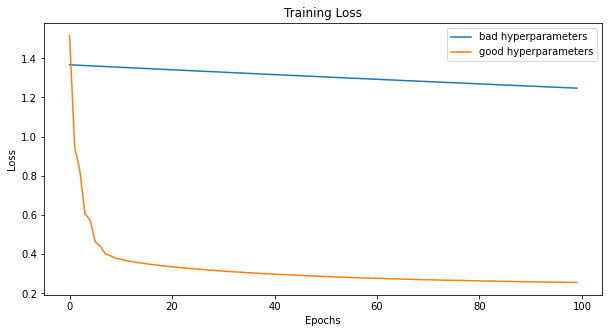

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(loss_bad, label='bad hyperparameters')
ax.plot(loss_good, label='good hyperparameters')
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")

g) Print the confusion matrix related to the test set.

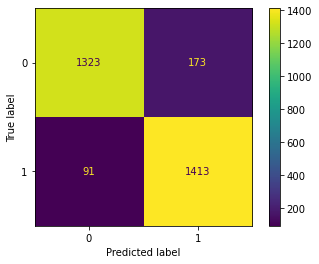

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_2, y_pred_2_good)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis")
    
plt.show()

<hr>

## **3)** Random forest

a) Load the data into a pandas DataFrame, and get a scikit-learn compatible dataset.

In [18]:
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

data3 = pd.read_csv("adult.data", header=None, names=columns)

partial_data_3 = data3.head(int(data3.shape[0])).head(1000)

features_3 = [x for x in partial_data_3.columns.drop("income")]

X_3 = partial_data_3[features_3]
y_3 = partial_data_3["income"]

b) Make a 70%/30% split of the dataset for training and testing respectively.

In [19]:
# train test split of data3
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.30, random_state=0)

print(f"Tamanho de treino: {X_train_3.shape}")
print(f"Tamanho de teste: {X_test_3.shape}")

Tamanho de treino: (700, 14)
Tamanho de teste: (300, 14)


c) An implementation of the Random Forest algorithm, as described in Section 8.2.2 of the
Witten, James, Hastie & Tibshirani book. You should add the following options:
- A parameter num_features for the number of predictors to consider at each split
- A parameter num_trees to control the number of trees in the forest
- Parameters for controlling the growth of trees, you need to implement at least
two of the following:
    - Maximum level of the tree
    - Minimum number of observations in a node
    - Stopping criterion based on the proportion of classes in the node

### Decision Tree implementation

In [20]:
# function for entropy
def entropy(y):
    # get the unique samples
    unique_samples = set(y.flatten())
    entropy = 0
    # calculate the entropy
    for i in unique_samples:
        p = y[y == i].shape[0] / y.shape[0]
        entropy -= p * np.log2(p)
    return entropy

# function for information gain
def information_gain(parent, right, left):
    entropy_parent = entropy(parent)
    # calculate the weights for the children
    right_frac = right.shape[0] / parent.shape[0]
    left_frac = left.shape[0] / parent.shape[0]
    # calculate the information gain
    ig = entropy_parent - (right_frac * entropy(right) + left_frac * entropy(left))
    return ig

# Node class
class Node:
    def __init__(self, is_leaf=None,feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature # index of the feature
        self.threshold = threshold # value for threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = is_leaf

# Decision Tree class
class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, min_split = 2, max_depth=100, number_of_feats=None, min_samples_quant=2):
        self.min_split = min_split # minimum number of samples for a split
        self.max_depth = max_depth # maximum depth of the tree
        self.number_of_feats = number_of_feats # number of features to use
        self.root = None
        self.min_samples_quant = min_samples_quant # number of categories in the remaing cut
    
    # calculate the most commom value in the array
    def _majority_vote(self, y):
        unique_samples = set(y.flatten())
        max_count = 0
        max_label = None
        for i in unique_samples:
            count = y[y == i].shape[0]
            if count > max_count:
                max_count = count
                max_label = i
        return max_label

    # function for splitting the data
    def _find_best_split(self, X, random_feat):
        feat_cut = None
        threshold = None
        best_ig = -1
        for i in random_feat:
            for j in np.unique(X[:, i].flatten()):
                # get the right and left data
                right = X[X[:, i] > j][:,i]
                left = X[X[:, i] <= j][:,i]
                # calculate the information gain
                ig = information_gain(X[:, i], right, left)
                if ig > best_ig:
                    best_ig = ig
                    feat_cut = i
                    threshold = j
        # return the best cut and its threshold
        return feat_cut, threshold
    
    # function for creating the tree
    def _build_tree(self, X, y, depth=0):
        # number of different labels in the data
        n_labels = len(np.unique(y))

        # bool variable for growth stopping
        criterias = (depth >= self.max_depth) or \
            (n_labels == self.min_samples_quant) or \
            (len(X) <= self.min_split)

        # stop the growth if the criterias are met
        if criterias:
            return Node(is_leaf=True, value=self._majority_vote(y))
        
        # choose random features if needed
        random_feat = np.random.choice(X.shape[1], self.number_of_feats, replace=False)
        
        # find the best split
        feat_cut, threshold = self._find_best_split(X, random_feat)
        
        # create the left and right nodes
        left = self._build_tree(X[X[:, feat_cut] <= threshold], y[X[:, feat_cut] <= threshold], depth + 1)
        right = self._build_tree(X[X[:, feat_cut] > threshold], y[X[:, feat_cut] > threshold], depth + 1)
        
        # return the root node
        return Node(is_leaf=False, feature=feat_cut, threshold=threshold, left=left, right=right)

    def fit(self, X, y):
        # Verifica se n_feat é None
        if self.number_of_feats is None:
            # define the number of features to use as the total
            self.number_of_feats = X.shape[1]
        else:
            # define the number of features
            self.number_of_feats = min(self.number_of_feats, X.shape[1])
        
        # build the tree
        self.root = self._build_tree(X, y)

    # function for predicting the data
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    # function for making a prediction
    def make_prediction(self, x, tree):
        # traverse the tree, stop if the node is a leaf
        if tree.is_leaf: 
            return tree.value
        feature_val = x[tree.feature]
        
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        return self.make_prediction(x, tree.right)

### Decision Tree tests:

In [21]:
tree_test = DecisionTree(min_split=2, max_depth=5, number_of_feats=None, min_samples_quant=1)
tree_test.fit(X_train_3.to_numpy(), y_train_3.to_numpy())
pred_tree = tree_test.predict(X_test_3.to_numpy())

In [22]:
accuracy_score(y_test_3, pred_tree)

0.7633333333333333

### Random Forest implementation

In [23]:
# Random Forest class
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_tree=100, max_depth=100, min_samples_quant=1, number_of_feats=None, min_split=2):
        self.n_tree = n_tree # number of trees in the forest
        self.max_depth = max_depth # maximum depth of the tree
        self.min_samples_quant = min_samples_quant # number of categories in the remaing cut
        self.number_of_feats = number_of_feats # number of features to use
        self.min_split = min_split
        self.Dtrees = []

        # set the seed
        self.rng = np.random.default_rng(0)

    # function for bootstrapping the data
    def _bootstrap(self, X, y):
        n_samples = X.shape[0]
        idx = self.rng.choice(n_samples, n_samples, replace=True)
        return X[idx], y[idx]
        
    def fit(self, X, y):
        # Get the input right
        X = X.to_numpy()
        y = y.to_numpy()
        self.Dtrees = []

        # create the trees
        for i in range(self.n_tree):
            tree = DecisionTree(min_split=self.min_split, max_depth=self.max_depth, \
                number_of_feats=self.number_of_feats, min_samples_quant=self.min_samples_quant)
            X_boot, y_boot = self._bootstrap(X, y)
            tree.fit(X_boot, y_boot)
            self.Dtrees.append(tree)

    def predict(self, X):
        # get the input right
        X = X.to_numpy()

        preds = []
        # make the predictions
        for tree in self.Dtrees:
            preds.append(tree.predict(X))

        # swap axes to see wich class is the most common
        preds = np.array(preds)
        preds = np.swapaxes(preds, 0, 1)

        return np.array([self._majority_vote(x) for x in preds])

    # function to see the most common class
    def _majority_vote(self, row):
        a, _ = np.unique(row, return_counts=True)
        return a[0]

    # calculate the probability of positive class
    def _probability(self, row):
        return np.count_nonzero(row == 1) / len(row)

    def predict_proba(self, X):
        X = X.to_numpy()
        preds = []
        for tree in self.Dtrees:
            preds.append(tree.predict(X))

        preds = np.array(preds)
        preds = np.swapaxes(preds, 0, 1)
        
        proba = np.array([self._probability(x) for x in preds])
        return np.c_[1-proba, proba]

### Random forest test

In [24]:
forest_test = RandomForest(n_tree=5, max_depth=5, min_samples_quant=1, number_of_feats=None, min_split=1)
forest_test.fit(X_train_3, y_train_3)
pred_forest = forest_test.predict(X_test_3)
accuracy_score(y_test_3, pred_forest)

0.7866666666666666

<hr>

## **4)** Performance comparison

### My classifiers

a) Use your classifiers (multi-layer perceptron classifier and random forest).
- Train them on the training set.
- Make predictions on the test set

In [25]:
mine_mlp = NeuralNetClass(hidden_layer_dimensions=[100, 100, 100, 100, 100], learning_rate=0.0001, batch_size=1000, epochs=100)
mine_mlp.fit(X_train_2, y_train_2)

print(mine_mlp.predict(X_test_2))

print(classification_report(y_test_2, mine_mlp.predict(X_test_2)))

[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      1496
         1.0       0.89      0.94      0.91      1504

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [26]:
forest_test = RandomForest(n_tree=5, max_depth=10, number_of_feats=None, min_split=2)
forest_test.fit(X_train_2.head(70), y_train_2.head(70))

pred_forest = forest_test.predict(X_test_2.head(30))

print(classification_report(y_test_2.head(30), pred_forest))

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       1.00      0.53      0.69        17

    accuracy                           0.73        30
   macro avg       0.81      0.76      0.73        30
weighted avg       0.83      0.73      0.72        30



### Scikit classifiers

b) Choose any 3 classifiers from scikit-learn and repeat steps in a) for each classifier. You
can find a list of classifiers on the scikit-learn documentation.


In [27]:
from sklearn.neural_network import MLPClassifier

nc = MLPClassifier(random_state=0, max_iter=100)
nc.fit(X_train_2, y_train_2)

print(nc.predict(X_test_2))

print(classification_report(y_test_2, nc.predict(X_test_2)))

[0. 0. 0. ... 1. 1. 1.]
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1496
         1.0       0.90      0.94      0.92      1504

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



d:\Programas\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
from sklearn import tree
tree_class = tree.DecisionTreeClassifier()
tree_class = tree_class.fit(X_train_2, y_train_2)

print(tree_class.predict(X_test_2))

print(classification_report(y_test_2, tree_class.predict(X_test_2)))

[1. 0. 0. ... 0. 1. 0.]
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      1496
         1.0       0.87      0.89      0.88      1504

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



In [29]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian = gaussian.fit(X_train_2, y_train_2)

print(gaussian.predict(X_test_2))

print(classification_report(y_test_2, gaussian.predict(X_test_2)))

[0. 0. 1. ... 1. 1. 1.]
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77      1496
         1.0       0.76      0.84      0.80      1504

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.79      0.79      0.78      3000



c) You will have obtained 5 sets of predictions from all the models you trained. Use these
predictions and the labels from the test set to calculate the performance of each model
using the following performance metrics:
- Precision
- Recall
- AUC-ROC
- AUC-PR

### Comparisions

In [34]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
models = [forest_test, mine_mlp, nc, tree_class, gaussian]
names = ["Random Forest", "NeuralNet", "Nearest Centroid", "Decision Tree", "Naive Bayes"]

X_test_2
y_test_2
precisions = []
recalls = []
PRs = []
ROCs = []

for i in range(len(models)):
    y_pred_2 = models[i].predict(X_test_2)
    y_pred_2_proba = models[i].predict_proba(X_test_2)[:,1]
    print(f"_____________{names[i]}______________\n")
    precisions.append(round(precision_score(y_test_2, y_pred_2), 3))
    print(f"precision: {precisions[-1]}")
    recalls.append(round(recall_score(y_test_2, y_pred_2), 3))
    print(f"recall: {recalls[-1]}")
    PRs.append(round(average_precision_score(y_test_2, y_pred_2_proba), 3))
    print(f"PR score: {PRs[-1]}")
    ROCs.append(round(roc_auc_score(y_test_2, y_pred_2_proba),3))
    print(f"ROC score: {ROCs[-1]}")
    print()
print("______________________________________")

_____________Random Forest______________

precision: 0.955
recall: 0.467
PR score: 0.896
ROC score: 0.919

_____________NeuralNet______________

precision: 0.892
recall: 0.938
PR score: 0.956
ROC score: 0.966

_____________Nearest Centroid______________

precision: 0.902
recall: 0.941
PR score: 0.956
ROC score: 0.967

_____________Decision Tree______________

precision: 0.873
recall: 0.888
PR score: 0.832
ROC score: 0.879

_____________Naive Bayes______________

precision: 0.756
recall: 0.844
PR score: 0.854
ROC score: 0.873

______________________________________


d) Create a comparison report. Your code will:
- Print a table with values of the performance metric (columns) for each model
(rows) on the test set.
- Make a single figure containing 2 subplots. In the first subplot, you will plot the
ROC curves for each model. In the second subplot, you will plot the PR curves for
each model

In [31]:
df = pd.DataFrame(list(zip(precisions, recalls, PRs, ROCs)),
               columns =['Precison', 'Recall', 'AUC', 'ROC'],
               index=names)
df

,Precison,Recall,AUC,ROC
Random Forest,0.955,0.467,0.713,0.723
NeuralNet,0.892,0.938,0.868,0.912
Nearest Centroid,0.902,0.941,0.878,0.919
Decision Tree,0.873,0.888,0.832,0.879
Naive Bayes,0.756,0.844,0.716,0.785


Text(0.5, 1.0, 'Precision-Recall curve')

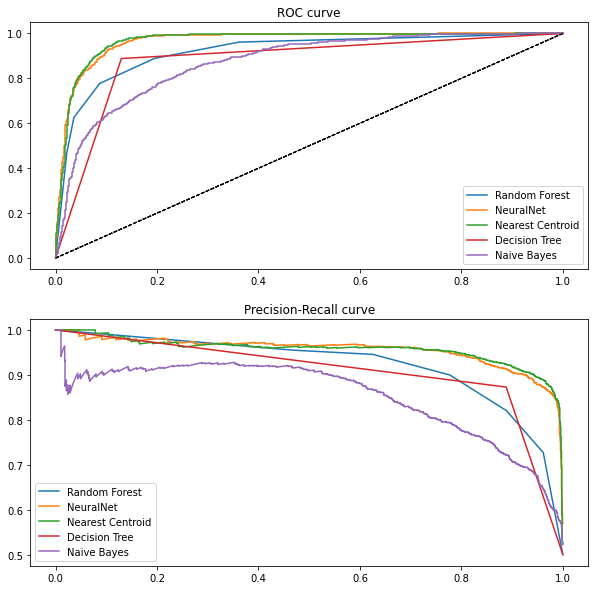

In [43]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fig, ax = plt.subplots(2, figsize=(10,10))

for i in range(len(models)):
    fpr, tpr, thresholds = roc_curve(y_test_2, models[i].predict_proba(X_test_2)[:,1])
    ax[0].plot(fpr, tpr, label=names[i])
    ax[0].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax[0].legend()

    recall, precision, thresholds = precision_recall_curve(y_test_2, models[i].predict_proba(X_test_2)[:,1])
    ax[1].plot(precision, recall, label=names[i])
    ax[1].legend()

ax[0].set_title("ROC curve")
ax[1].set_title("Precision-Recall curve")

In [ ]:

for i in range(len(pred)):
    fpr, tpr, _ = metrics.roc_curve(y2_test, pred[i])
    auc = round(metrics.roc_auc_score(y2_test, pred[i]), 4)
    ax1.plot(fpr,tpr,label=label[i]+", AUC="+str(auc))
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

for i in range(len(pred)):
    precision, recall, _ = metrics.precision_recall_curve(y2_test, pred[i])
    auc_pr = round(metrics.auc(recall, precision), 4)
    ax2.plot(recall, precision, label=label[i]+", AUC-PR="+str(auc_pr))